*This blog post benchmarks different compressors for use with genotype data from large-scale resequencing projects. TL;DR for speed you can't beat Blosc+LZ4, but Blosc+Zstd+Bitshuffle gives a very high compression ratio with good all-round performance.*

## About the data

The data used in this benchmark are genotype data from the [Ag1000G project phase 1 AR3 data release](@@TODO). The goal of this benchmark is compare compression ratio and speed of compression and decompression for a variety of different compressors. For convenience I won't use all of the data, but will extract a sample of 2 million rows from a genotype array.

In [1]:
import h5py
callset = h5py.File('/kwiat/2/coluzzi/ag1000g/data/phase1/release/AR3/variation/main/hdf5/ag1000g.phase1.ar3.pass.3R.h5',
                    mode='r')
data = callset['3R/calldata/genotype'][5000000:7000000]

In uncompressed form, the genotype data are structured as a 3-dimensional array of 1-byte integers. The first dimension represents positions in the genome where genetic differences are observed between one or more individuals. The second dimension represents individuals (e.g., humans if you are doing human genetics, mosquitoes if you are doing mosquito genetics, etc.). The third dimension represents ploidy, which for organisms like humans or mosquitoes is always 2 (we each carry two genome copies, one from each of our parents).

In [2]:
data.dtype

dtype('int8')

In [3]:
data.shape

(2000000, 765, 2)

In [4]:
import humanize
print('benchmark data uncompressed size:', humanize.naturalsize(data.nbytes))

benchmark data uncompressed size: 3.1 GB


The integer values in the array represent different DNA nucleotides (A, C, G, T, missing). However, rather than have a fixed code (0->A, 1->C, etc.), the encoding is based on comparison with a reference nucleotide sequence for the species being studied. A value of 0 means identical to the reference, a value of 1 or greater means different from the reference, and a negative value means missing. 

Because most individuals within a species share much of their DNA sequence in common with each other, genotype data are generally very sparse, in the sense that the vast majority of values are zero (identical to the reference). This sparseness is the main reason why genotype data compress well. Also, for organisms like humans where genetic diversity is relatively low, almost all non-zero values are 1. For organisms like mosquitoes where diversity is higher, a larger fraction of values can be greater than 1, although the data are still very sparse. If we are dealing with nucleotide variation (as is the case here) the maximum value is 3.

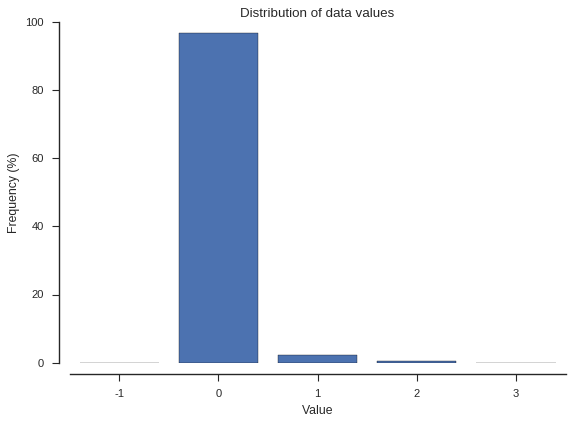

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 80
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')

mn = data.min()
mx = data.max()
x = np.arange(mn, mx + 1)
# split bincount in two to avoid memory error
y = np.bincount(data[:1000000].reshape(-1) - mn)
y += np.bincount(data[1000000:2000000].reshape(-1) - mn)

fig, ax = plt.subplots()
sns.despine(ax=ax, offset=10)
ax.bar(x + .1, y * 100 / y.sum(), width=.8)
ax.set_xticks(x + .5)
ax.set_xticklabels(x)
ax.set_xlabel('Value')
ax.set_ylabel('Frequency (%)')
ax.set_title('Distribution of data values');

For the benchmark I'm going to store the data via [Zarr](@@TODO) which splits the data into chunks and compresses each chunk separately. Compressed data will be stored in and retrieved from main memory. We usually choose a chunk shape that provides a good trade-off between row-wise and column-wise data access, and use chunk sizes of 1 megabyte or greater.

In [6]:
chunks = (20000, 45, 2)
from functools import reduce
import operator
print('uncompressed chunk size:', humanize.naturalsize(reduce(operator.mul, chunks)))

uncompressed chunk size: 1.8 MB


## About the compressors

The Python standard library provides three compression libraries: [Zlib](), [BZ2]() and [LZMA](). I'm including these in the benchmark for comparison, however these are typically too slow for interactive data analysis. The main comparisons will be between different configurations of the [Blosc](@@TODO) compression library. 

[Blosc](@@TODO) is a meta-compressor which accelerates compression by using multiple threads and by splitting data into smaller blocks that fit well with CPU cache architecture. There are a number of different compression algorithms which can be used within Blosc, including LZ4, Zstandard, Zlib and BloscLZ. Blosc also provides hardware-optimized implementations of shuffle filters, which can improve compression ratio for some data. Because I am dealing with single-byte data, I am particularly interested in how the bit-shuffle filter affects compression ratio and performance.

In [7]:
import zarr
from zarr import Zlib, BZ2, LZMA, Blosc
from zarr.blosc import NOSHUFFLE, BITSHUFFLE
compressors = (
    None,
    Zlib(level=1),
    BZ2(level=1),
    LZMA(preset=1),
    Blosc(clevel=0, shuffle=NOSHUFFLE),
    Blosc(cname='snappy', clevel=9, shuffle=NOSHUFFLE),
    Blosc(cname='blosclz', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='blosclz', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='blosclz', clevel=9, shuffle=NOSHUFFLE),
    Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='lz4', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='lz4', clevel=9, shuffle=NOSHUFFLE),
    Blosc(cname='lz4hc', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='lz4hc', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='zlib', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='zstd', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='zstd', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='snappy', clevel=9, shuffle=BITSHUFFLE),
    Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='blosclz', clevel=5, shuffle=BITSHUFFLE),
    Blosc(cname='blosclz', clevel=9, shuffle=BITSHUFFLE),
    Blosc(cname='lz4', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='lz4', clevel=5, shuffle=BITSHUFFLE),
    Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE),
    Blosc(cname='lz4hc', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='lz4hc', clevel=5, shuffle=BITSHUFFLE),
    Blosc(cname='zlib', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='zlib', clevel=5, shuffle=BITSHUFFLE),
    Blosc(cname='zstd', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='zstd', clevel=5, shuffle=BITSHUFFLE),
)

Note that ``NOSHUFFLE`` and ``BITSHUFFLE`` are numeric constants with values 0 and 2 respectively:

In [8]:
NOSHUFFLE

0

In [9]:
BITSHUFFLE

2

## Compression ratio

In [10]:
def calc_ratios():
    ratios = list()
    for compressor in compressors:
        z = zarr.array(data, chunks=chunks, compressor=compressor)
        ratio = z.nbytes / z.nbytes_stored
        ratios.append(ratio)
    return ratios


In [11]:
data_dir = '../assets/2016-09-21-genotype-compression-benchmark_data'

In [12]:
import os
ratios_fn = os.path.join(data_dir, 'ratios.npy')
if os.path.exists(ratios_fn):
    ratios = np.load(ratios_fn)
else:
    ratios = calc_ratios()
    np.save(ratios_fn, ratios)


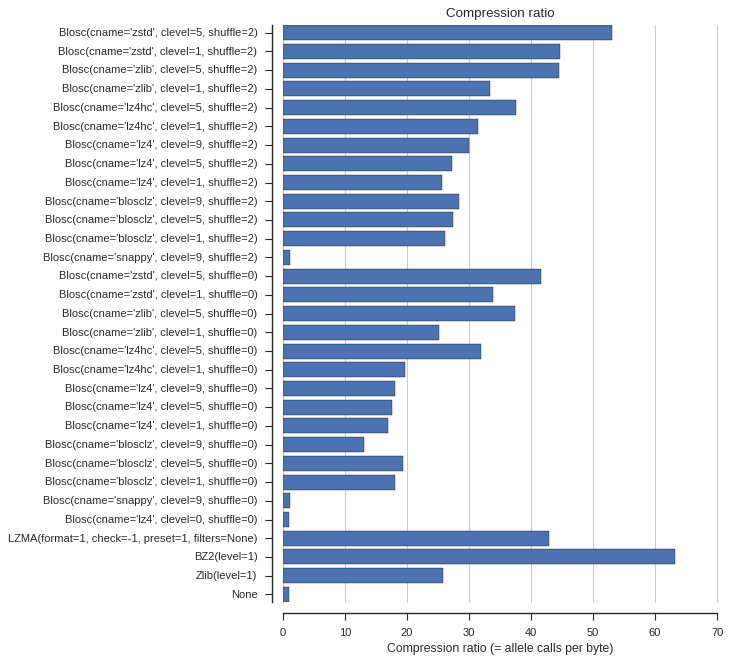

In [13]:
fig, ax = plt.subplots(figsize=(7, len(compressors) * .3))
sns.despine(ax=ax, offset=10)
ax.barh(bottom=np.arange(len(compressors)), width=ratios, height=.8)
ax.set_yticks(np.arange(len(compressors)) + .4)
ax.set_yticklabels([repr(c) for c in compressors])
ax.grid(axis='x')
ax.set_xlabel('Compression ratio (= allele calls per byte)')
ax.autoscale(axis='y')
ax.set_title('Compression ratio', va='bottom');

## Compression and decompression speed

For this benchmark data are compressed and decompressed to main memory.

In [14]:
from zarr import blosc
import timeit

In [15]:
def bench_performance(repeat=10, number=1, blosc_nthreads=1):
    blosc.set_nthreads(blosc_nthreads)
    compress_times = list()
    decompress_times = list()
    for compressor in compressors:
        
        # benchmark compression
        z = zarr.empty_like(data, chunks=chunks, compressor=compressor)
        context = dict(z=z, data=data)
        compress_stmt = 'z[:] = data'
        t = timeit.Timer(stmt=compress_stmt, globals=context)
        c = t.repeat(repeat=repeat, number=number)
        compress_times.append(c)
        
        # benchmark decompression
        decompress_stmt = '_ = z[:]'
        t = timeit.Timer(stmt=decompress_stmt, globals=context)
        d = t.repeat(repeat=repeat, number=number)
        decompress_times.append(d)
        
    return compress_times, decompress_times

In [16]:
# this takes a long time, so only run once and save results
import os
times_fn = os.path.join(data_dir, 'times.npz')

In [17]:
if not os.path.exists(times_fn):
    compress_times, decompress_times = bench_performance(blosc_nthreads=1)
    mt_compress_times, mt_decompress_times = bench_performance(blosc_nthreads=8)
    np.savez(times_fn, 
             compress_times=compress_times, 
             decompress_times=decompress_times, 
             mt_compress_times=mt_compress_times,
             mt_decompress_times=mt_decompress_times)
else:
    times = np.load(times_fn)
    compress_times = times['compress_times']
    decompress_times = times['decompress_times']
    mt_compress_times = times['mt_compress_times']
    mt_decompress_times = times['mt_decompress_times']

In [18]:
def plot_speed(times, title, xlim=(0, 4100)):
    fig, ax = plt.subplots(figsize=(7, len(compressors) * .3))
    sns.despine(ax=ax, offset=10)
    # use best run
    x = np.array(times).min(axis=1)
    # convert time into speed (M/second)
    x = (data.nbytes / 2**20) / x
    ax.barh(bottom=np.arange(len(compressors)), width=x, height=.8)
    ax.set_yticks(np.arange(len(compressors)) + .4)
    ax.set_yticklabels([repr(c) for c in compressors])
    ax.grid(axis='x')
    ax.set_xlabel('Speed (M/s)')
    ax.autoscale(axis='y', tight=True)
    ax.set_xlim(*xlim)
    ax.set_title(title, va='bottom')
    for i, (xi, ri) in enumerate(zip(x, ratios)):
        ax.annotate('%.1fX' % ri, xy=(xi, i+.4), xytext=(5, 0), 
                    textcoords='offset points', ha='left', va='center',
                    fontsize=8)

Below are several plots of compression and decompression speed. In the plots I've included the compression ratios as well as annotations (e.g., "53.7X") for easy reference. Note that ``clevel=0`` means no compression. 

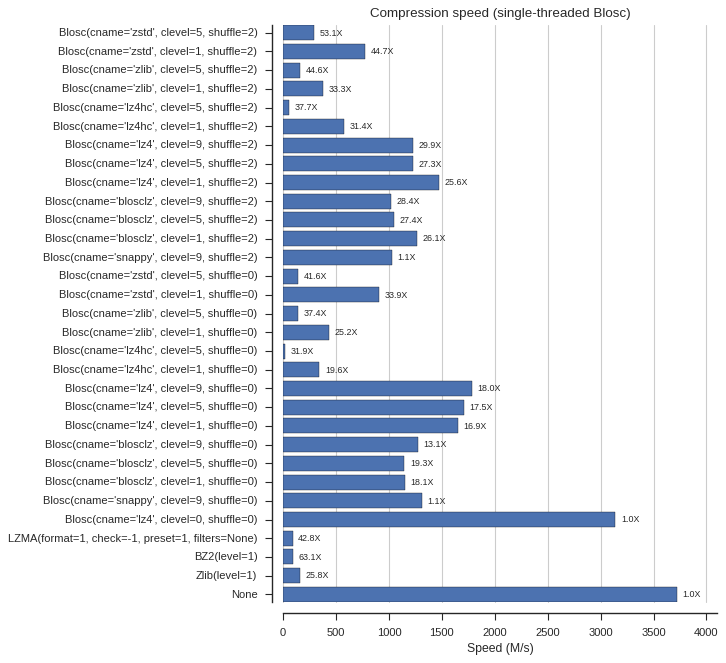

In [19]:
plot_speed(compress_times, 'Compression speed (single-threaded Blosc)')

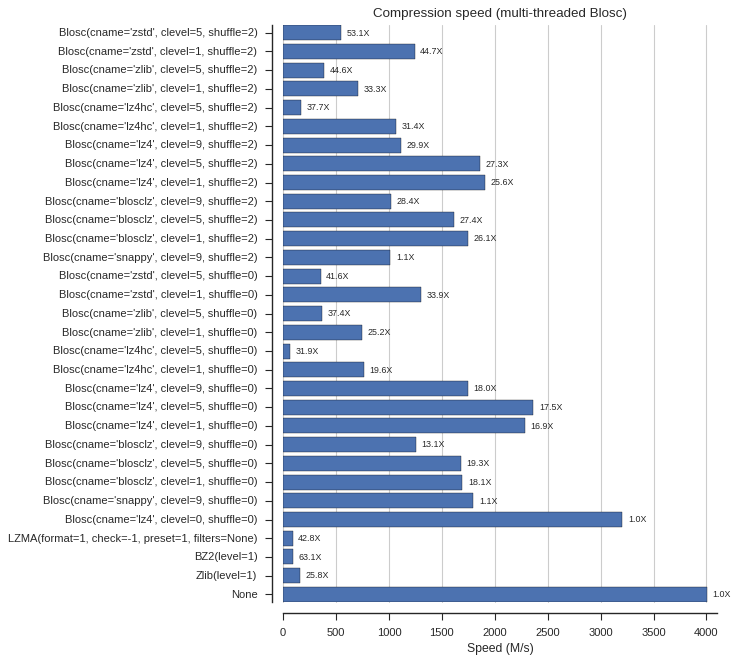

In [20]:
plot_speed(mt_compress_times, 'Compression speed (multi-threaded Blosc)')

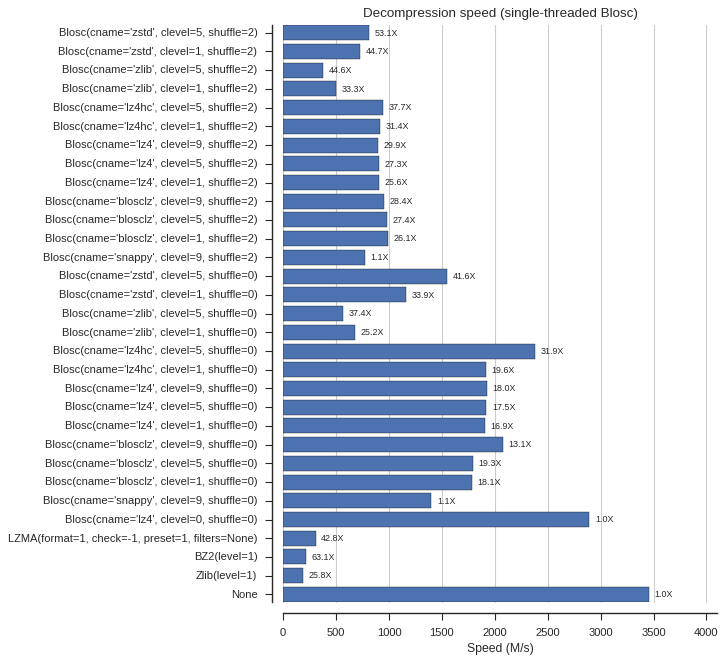

In [21]:
plot_speed(decompress_times, 'Decompression speed (single-threaded Blosc)')

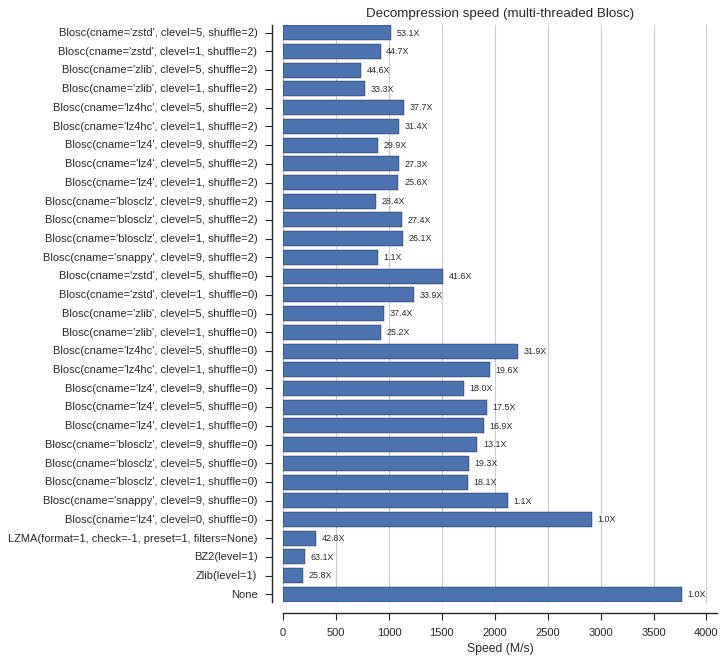

In [22]:
plot_speed(mt_decompress_times, 'Decompression speed (multi-threaded Blosc)')

## Summary

In [23]:
palette = sns.color_palette('Set1', n_colors=7)
#sns.palplot(palette);

colors = np.array([
    palette[0] if not isinstance(c, Blosc)
    else palette[1] if c.cname == b'snappy'
    else palette[2] if c.cname == b'blosclz'
    else palette[3] if c.cname == b'lz4'
    else palette[4] if c.cname == b'lz4hc'
    else palette[5] if c.cname == b'zlib'
    else palette[6] if c.cname == b'zstd'
    else 'k'
    for c in compressors
])

def plot_summary(ctimes, dtimes, xlim=(0, 2500), ylim=(0, 2500), annotate=[], title=None, alpha=1):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.despine(ax=ax, offset=10)
    if title:
        ax.set_title(title, va='bottom')
    
    # use best run
    x = np.array(ctimes).min(axis=1)
    # convert time into speed (M/second)
    x = (data.nbytes / 2**20) / x
    # use best run
    y = np.array(dtimes).min(axis=1)
    # convert time into speed (M/second)
    y = (data.nbytes / 2**20) / y
    s = np.array(ratios) * 5
    
    is_bitshuffle = np.array([isinstance(c, Blosc) and c.shuffle == BITSHUFFLE for c in compressors])
    bs_marker = 'h'
    ns_marker = 'o'
    ax.scatter(x[is_bitshuffle], y[is_bitshuffle], s[is_bitshuffle], color=colors[is_bitshuffle], 
               marker=bs_marker, alpha=alpha)
    ax.scatter(x[~is_bitshuffle], y[~is_bitshuffle], s[~is_bitshuffle], color=colors[~is_bitshuffle], 
               marker=ns_marker, alpha=alpha)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('Compression speed (M/s)')
    ax.set_ylabel('Decompression speed (M/s)')
    
    for i, (xi, yi, ri, c) in enumerate(zip(x, y, ratios, compressors)):
        if i in annotate:
            ax.annotate('%.1fX %r' % (ri, c), xy=(xi, yi), xytext=(25, 0), va='center', ha='left',
                        textcoords='offset points', arrowprops=dict(arrowstyle="wedge"), fontsize=8)
    
    # color legend
    import matplotlib.lines as mlines
    handles = [
        mlines.Line2D([], [], color=color, marker=ns_marker, linestyle=' ',
                      markersize=10, label=label, alpha=alpha)
        for color, label in zip(
            palette,
            ['other', 'blosc+snappy', 'blosc+blosclz', 'blosc+lz4', 'blosc+lz4hc', 'blosc+zlib', 'blosc+zstd']
        )
    ]
    handles += [
        mlines.Line2D([], [], color='k', marker=ns_marker, linestyle=' ',
                      markersize=10, label='NOSHUFFLE', alpha=alpha),
        mlines.Line2D([], [], color='k', marker=bs_marker, linestyle=' ',
                      markersize=10, label='BITSHUFFLE', alpha=alpha)
        
    ]
    handles += [
        mlines.Line2D([], [], color='k', marker=ns_marker, linestyle=' ',
                      markersize=np.sqrt(x*5), label='%sX compression ratio' % x, alpha=alpha)
        for x in [10, 20, 30, 40, 50]
        
    ]
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1, 0), ncol=2)


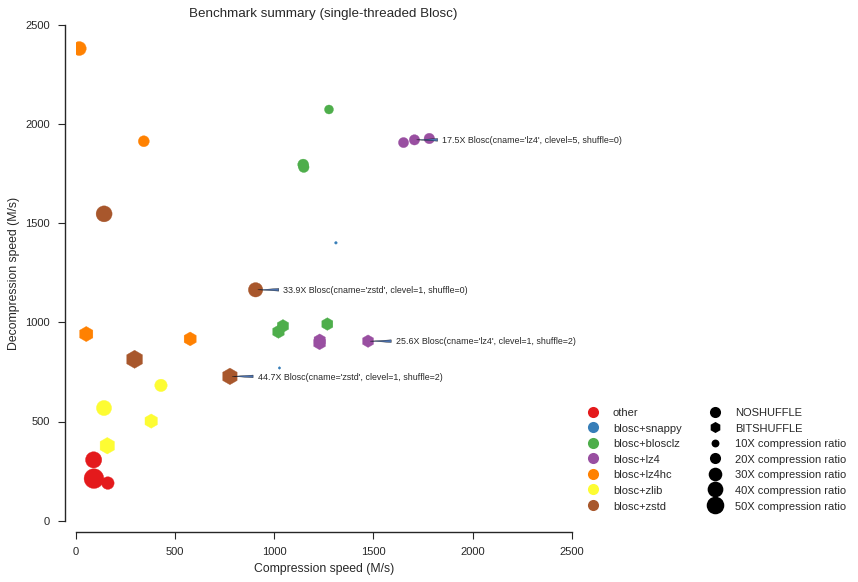

In [24]:
annotate = [10, 16, 22, 29]
plot_summary(compress_times, decompress_times, annotate=annotate, 
             title='Benchmark summary (single-threaded Blosc)')

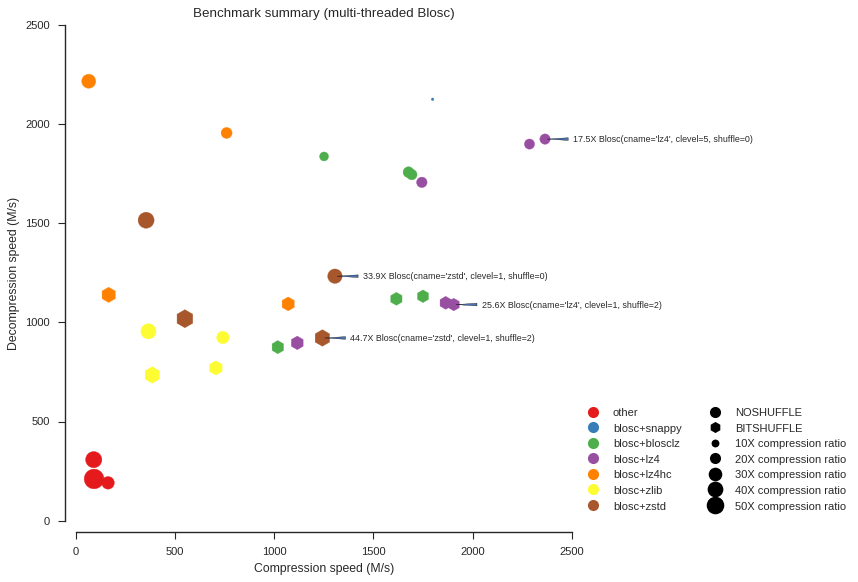

In [25]:
annotate = [10, 16, 22, 29]
plot_summary(mt_compress_times, mt_decompress_times, annotate=annotate, 
             title='Benchmark summary (multi-threaded Blosc)')

## Conclusions

* For maximum all-round speed, Blosc with LZ4 and no shuffle is the best option.
* For higher compression ratios, Blosc with Zstandard is excellent. Adding the bit-shuffle filter increases compression ratio even further at a modest cost to decompression speed.

## Further reading

* [Blosc web site](http://www.blosc.org/)
* [Zstandard web site](@@TODO)
* [Zstandard GitHub repo](@@TODO)
* [Bitshuffle GitHub repo](https://github.com/kiyo-masui/bitshuffle)
* [New "bitshuffle" filter](http://www.blosc.org/blog/new-bitshuffle-filter.html) - blog post by Francesc Alted with further benchmarks using the bit-shuffle filter
* [Zstd has just landed in Blosc](http://www.blosc.org/blog/zstd-has-just-landed-in-blosc.html) - blog post by Francesc Alted with further benchmarks using Zstandard
* [Zarr documentation](@@TODO)
* [*Anopheles gambiae* 1000 genomes project](@@TODO)

## Post-script: system information

In [26]:
import cpuinfo
cpuinfo.main()

Vendor ID: GenuineIntel
Hardware Raw: 
Brand: Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz
Hz Advertised: 2.8000 GHz
Hz Actual: 1.4000 GHz
Hz Advertised Raw: (2800000000, 0)
Hz Actual Raw: (1400000000, 0)
Arch: X86_64
Bits: 64
Count: 8
Raw Arch String: x86_64
L2 Cache Size: 8192 KB
L2 Cache Line Size: 0
L2 Cache Associativity: 0
Stepping: 3
Model: 94
Family: 6
Processor Type: 0
Extended Model: 0
Extended Family: 0
Flags: 3dnowprefetch, abm, acpi, adx, aes, aperfmperf, apic, arat, arch_perfmon, avx, avx2, bmi1, bmi2, bts, clflush, clflushopt, cmov, constant_tsc, cx16, cx8, de, ds_cpl, dtes64, dtherm, dts, eagerfpu, epb, ept, erms, est, f16c, flexpriority, fma, fpu, fsgsbase, fxsr, hle, ht, hwp, hwp_act_window, hwp_epp, hwp_noitfy, ida, invpcid, lahf_lm, lm, mca, mce, mmx, monitor, movbe, mpx, msr, mtrr, nonstop_tsc, nopl, nx, pae, pat, pbe, pcid, pclmulqdq, pdcm, pdpe1gb, pebs, pge, pln, pni, popcnt, pse, pse36, pts, rdrand, rdseed, rdtscp, rep_good, rtm, sep, smap, smep, smx, ss, sse, ss

## Post-script: Blosc detailed benchmarks

### Compression level

In [27]:
def bench_blosc(cname, shuffle, nthreads, clevels=None, repeat=5, force=False):
    fn = os.path.join(data_dir, 'blosc.%s.%s.%s.npz' % (cname, shuffle, nthreads))
    if force or not os.path.exists(fn):
        blosc.set_nthreads(nthreads)

        ratios = list()
        compress_times = list()
        decompress_times = list()

        if clevels is None:
            clevels = range(1, 10)
        for clevel in clevels:
            compressor = Blosc(cname=cname, clevel=clevel, shuffle=shuffle)

            # find compression ratio
            z = zarr.array(data, chunks=chunks, compressor=compressor)
            ratio = z.nbytes / z.nbytes_stored
            ratios.append(ratio)

            # benchmark compression
            z = zarr.empty_like(data, chunks=chunks, compressor=compressor)
            context = dict(z=z, data=data)
            compress_stmt = 'z[:] = data'
            t = timeit.Timer(stmt=compress_stmt, globals=context)
            c = t.repeat(repeat=repeat, number=1)
            compress_times.append(c)

            # benchmark decompression
            decompress_stmt = '_ = z[:]'
            t = timeit.Timer(stmt=decompress_stmt, globals=context)
            d = t.repeat(repeat=repeat, number=1)
            decompress_times.append(d)

        results = dict(clevels=clevels, ratios=ratios, compress_times=compress_times, decompress_times=decompress_times)
        np.savez(fn, **results)
    
    else:
        results = np.load(fn)
        
    return results


In [28]:
shuffle_labels = ['NOSHUFFLE', 'SHUFFLE', 'BITSHUFFLE']

In [29]:
def plot_bench_blosc(cname, shuffle, nthreads, ax=None):
    fn = os.path.join(data_dir, 'blosc.%s.%s.%s.npz' % (cname, shuffle, nthreads))
    results = np.load(fn)
    palette = sns.color_palette()
    
    if ax is None:
        fig, ax = plt.subplots()
    sns.despine(ax=ax, offset=10)
    
    # plot ratios
    x = results['clevels']
    yr = results['ratios']
    ax.plot(x, yr, marker='o', color=palette[0], label='compression ratio')
    ax.set_ylim(0, 70)
    ax.set_ylabel('Compression ratio')
    ax.legend(loc='upper left')
    ax.set_xlabel('clevel')
    ax.set_xlim(.8, 9.2)
    
    # plot speeds
    ax = ax.twinx()
    sns.despine(ax=ax, left=True, bottom=True, right=False, offset=10)
    yc = (data.nbytes / 2**20) / results['compress_times'].min(axis=1)
    ax.plot(x, yc, marker='o', color=palette[2], label='compression')
    yd = (data.nbytes / 2**20) / results['decompress_times'].min(axis=1)
    ax.plot(x, yd, marker='o', color=palette[1], label='decompression')
    ax.set_ylim(0, 2800)
    ax.legend(loc='upper right')
    ax.set_ylabel('Speed (M/s)')
    ax.set_xlim(.8, 9.2)
    
    ax.set_title('cname=%r, shuffle=%s, nthreads=%s' % (cname, shuffle_labels[shuffle], nthreads))

In [30]:
def fig_blosc_bench(cname, nthreads, clevels=None):
    bench_blosc(cname, shuffle=NOSHUFFLE, nthreads=nthreads, clevels=clevels)
    bench_blosc(cname, shuffle=BITSHUFFLE, nthreads=nthreads, clevels=clevels)
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_bench_blosc(cname, shuffle=NOSHUFFLE, nthreads=nthreads, ax=ax)
    ax = fig.add_subplot(1, 2, 2)
    plot_bench_blosc(cname, shuffle=BITSHUFFLE, nthreads=nthreads, ax=ax)
    fig.tight_layout()

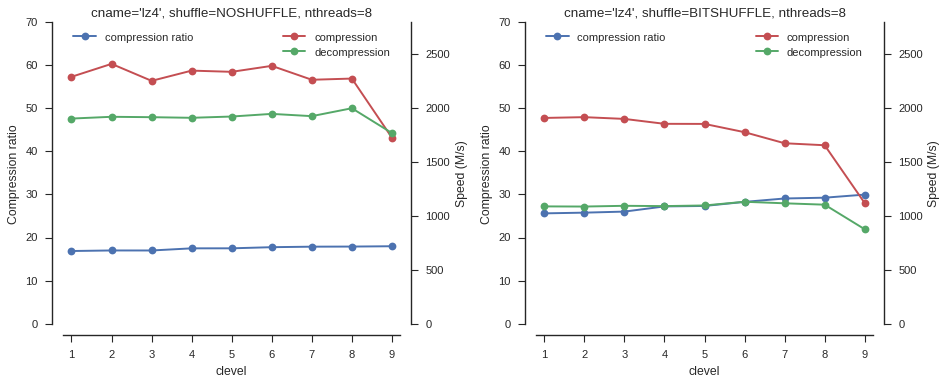

In [31]:
fig_blosc_bench('lz4', 8)

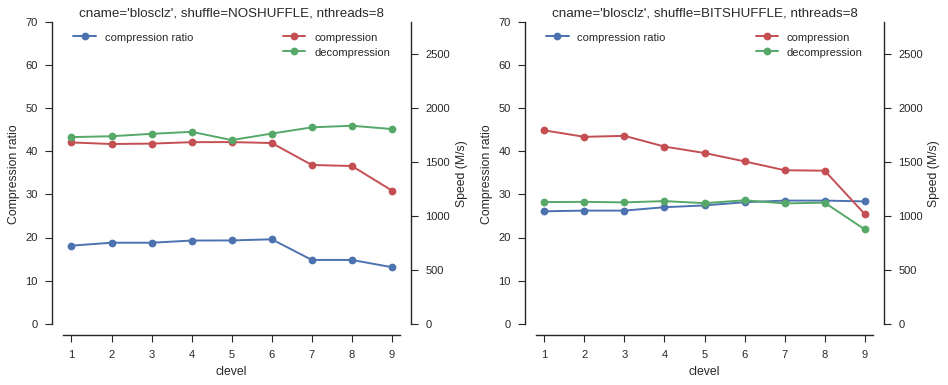

In [32]:
fig_blosc_bench('blosclz', 8)

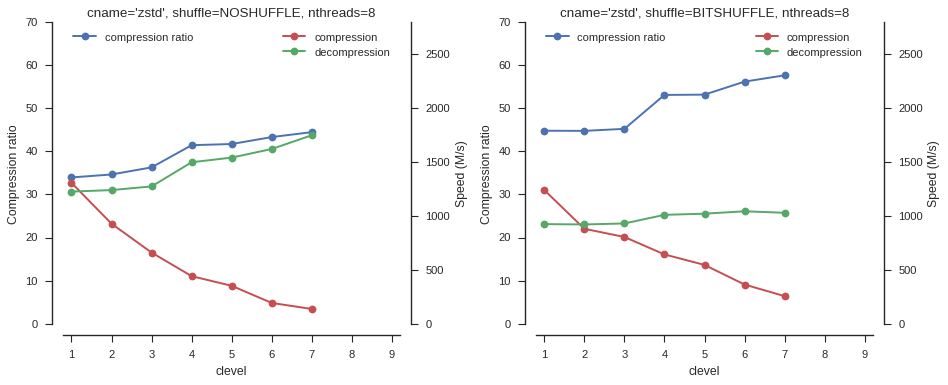

In [33]:
fig_blosc_bench('zstd', 8, clevels=range(1, 8))

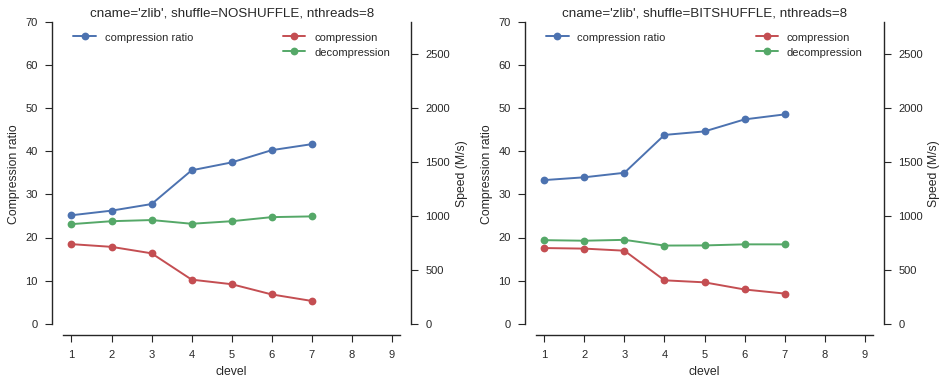

In [34]:
fig_blosc_bench('zlib', 8, clevels=range(1, 8))

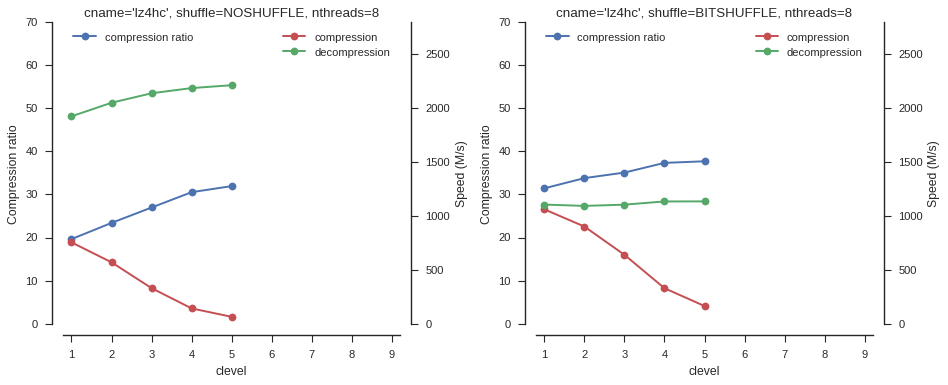

In [35]:
fig_blosc_bench('lz4hc', 8, clevels=range(1, 6))

### Number of threads